In [7]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import random
import tensorflow as tf


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define dataset path
open_eyes_path = "training_data/Open_Eyes"
closed_eyes_path = "training_data/Closed_Eyes"

# Initialize data arrays
X = []
y = []

# New image size and augmentation settings
IMG_SIZE = 48  # Increased from 24 to capture more details
CHANNELS = 1   # Keep grayscale but could change to 3 for RGB

# Load images with error handling
def load_images(folder_path, label):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith('.png'):
            try:
                image_path = os.path.join(folder_path, file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                # Verify image loaded correctly
                if image is None:
                    print(f"Warning: Could not read image {file}")
                    continue
                    
                # Resize and normalize
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
    return images, labels

# Load both classes
open_eyes, open_labels = load_images(open_eyes_path, 1)
closed_eyes, closed_labels = load_images(closed_eyes_path, 0)

# Combine datasets
X = np.array(open_eyes + closed_eyes)
y = np.array(open_labels + closed_labels)

# Check class balance
print(f"Class distribution: {np.bincount(y)}")
print(f"Open eyes: {len(open_eyes)} | Closed eyes: {len(closed_eyes)}")

# Normalize and reshape
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS) / 255.0
y = to_categorical(y, num_classes=2)

# Stratified split with shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y,
    shuffle=True
)

# Create data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

print(f"Dataset loaded: {len(X)} samples (Training: {len(X_train)}, Test: {len(X_test)})")

Class distribution: [2000 2000]
Open eyes: 2000 | Closed eyes: 2000
Dataset loaded: 4000 samples (Training: 3200, Test: 800)


In [9]:
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
model = Sequential([
    # Feature extraction
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Classification head
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Add learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Compile with lower initial learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\User\Desktop\BSCS\6th Semester\Computer Vision\CV project final\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,266 (2.48 MB)

 Trainable params: 650,818 (2.48 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 230ms/step - accuracy: 0.8394 - loss: 0.9729 - precision: 0.8394 - recall: 0.8394 - val_accuracy: 0.5000 - val_loss: 1.4027 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.9783 - loss: 0.6364 - precision: 0.9783 - recall: 0.9783 - val_accuracy: 0.5000 - val_loss: 1.9070 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.9912 - loss: 0.5936 - precision: 0.9912 - recall: 0.9912 - val_accuracy: 0.5225 - val_loss: 1.7740 - val_precision: 0.5225 - val_recall: 0.5225
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9954 - loss: 0.5777 - precision: 0.9954 - recall: 0.9954 - val_accuracy: 0.7812 - val_loss: 1.0420 - val_precision: 0.7812 - val_recall: 0.7812
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9963 - loss: 0.5685 - precision: 0.9963 - recall: 0.9963 - val_accuracy: 0.9137

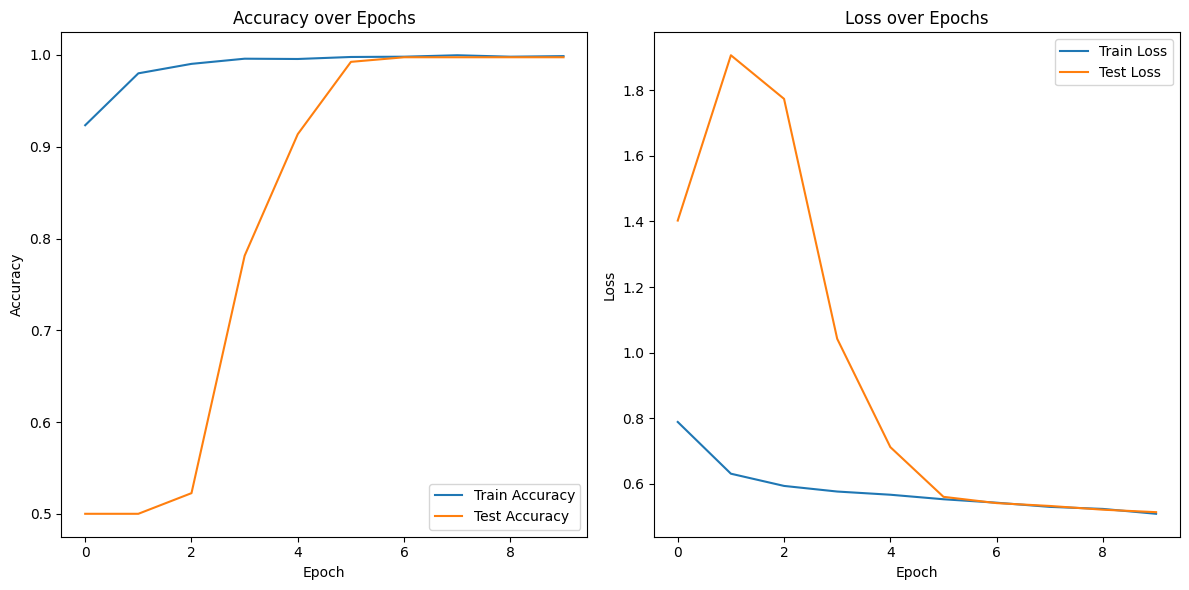

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training & validation accuracy/loss curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
model.save('drowsiness_model.h5')